### Background: Oil Volatility
Today's Date: June 21st 2025

Recently the conflict between Iran and Israel has been escalating. This has been pushing the oil prices higher and also the oil volatility.

>Friday, June 13, 2025 — Israel launches blistering attacks on the heart of Iran’s nuclear and military structure, deploying warplanes and drones previously smuggled into the country to assault key facilities and kill top generals and scientists.
> 
>[Source: AP News](https://apnews.com/article/israel-iran-timeline-tensions-conflict-66764c2843d62757d83e4a486946bcb8)


### Goal

The goal of this notebook is for us to process the signal(Ratio of OVX(Oil Volatiltiy) and VIX) and identify when to enter into a trade and exit the trade.

In [1]:
import sys
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np

import yfinance as yf
from fredapi import Fred

import matplotlib.pyplot as plt

In [2]:
import yahoo.code.support_functions as sf
import yahoo.code.plot_functions as pf
import yahoo.code.dislocation_analysis as da
import yahoo.code.option_strategy as OptS

### Fetch Data for the Signal


#### Brent vs WTI

TLDR; the differentiating factor is the market of the oil. WTI is US and Brent is for Europe, Africa, and the Middle East. 

- Brent Crude
  
  Brent Crude is the benchmark used for the light oil market in Europe, Africa, and the Middle East, originating from oil fields in the North Sea between the Shetland Islands and Norway.

- West Texas Intermediate (WTI)
  
  West Texas Intermediate is the benchmark for the U.S. light oil market and is sourced from U.S. oil fields


Although the Iran vs Israel conflict would impact Brent Crude base on the fact that the Middle East market is represented in Brent Crude, the WTL price also closely follows the Brent (Correlation of 0.82).

In [4]:
# Crude Oil Prices: Brent - Europe (DCOILBRENTEU)
brent_crude = da.extract_hist_fred("DCOILBRENTEU")
brent_crude.index = brent_crude.index.map(lambda x: pd.to_datetime(x).date())
# Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma (DCOILWTICO)
wti_crude = da.extract_hist_fred("DCOILWTICO")
wti_crude.index = wti_crude.index.map(lambda x: pd.to_datetime(x).date())

brent_crude = brent_crude.loc[brent_crude.index>datetime.date(2023,1,1),:]
wti_crude = wti_crude.loc[wti_crude.index>datetime.date(2023,1,1),:]


Long_Name='Crude Oil Prices: Brent - Europe'
Symbol='DCOILBRENTEU'
            Close
2025-06-12  70.84
2025-06-13  76.00
2025-06-16  75.05


Time Series data from 1987-05-20 to 2025-06-16. Total of 9934 observation
Long_Name='Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma'
Symbol='DCOILWTICO'
            Close
2025-06-12  68.73
2025-06-13  73.84
2025-06-16  72.53


Time Series data from 1986-01-02 to 2025-06-16. Total of 10293 observation


In [5]:
brent_crude.loc[:,'PCT_Change']=brent_crude['Close'].pct_change()
wti_crude.loc[:,'PCT_Change']=wti_crude['Close'].pct_change()

/var/folders/8f/xdn35nl14wgbcn6w02_slg6h0000gn/T/ipykernel_22581/1837467034.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  brent_crude.loc[:,'PCT_Change']=brent_crude['Close'].pct_change()
/var/folders/8f/xdn35nl14wgbcn6w02_slg6h0000gn/T/ipykernel_22581/1837467034.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  wti_crude.loc[:,'PCT_Change']=wti_crude['Close'].pct_change()


In [6]:
from scipy import stats
corr_value, p_val = stats.pearsonr(brent_crude['PCT_Change'][2:],wti_crude['PCT_Change'][2:])
print(corr_value, p_val)

0.8213467682184485 1.929150434891169e-157


In [7]:
vix_hist = da.extract_hist_yf("^VIX")

Error in getting ticker information 
 HTTP Error 401: 
                                Open       High        Low      Close
Date                                                                 
2025-06-17 00:00:00-05:00  20.530001  21.790001  19.549999  21.600000
2025-06-18 00:00:00-05:00  20.900000  21.580000  19.590000  20.139999
2025-06-20 00:00:00-05:00  20.740000  21.070000  19.110001  20.620001


Time Series data from 1990-01-02 to 2025-06-20. Total of 8933 observation


In [8]:
# CBOE Crude Oil Volatility Index, ^OVX
ovx_hist = da.extract_hist_yf("^OVX")

Long_Name='^OVX'
Symbol='^OVX'
                                Open       High        Low      Close
Date                                                                 
2025-06-17 00:00:00-04:00  61.500000  74.000000  60.810001  71.559998
2025-06-18 00:00:00-04:00  74.410004  74.410004  64.190002  66.860001
2025-06-20 00:00:00-04:00  65.480003  66.820000  63.580002  64.669998


Time Series data from 2007-05-10 to 2025-06-20. Total of 4557 observation


#### Plot of Oil Price and Volatility

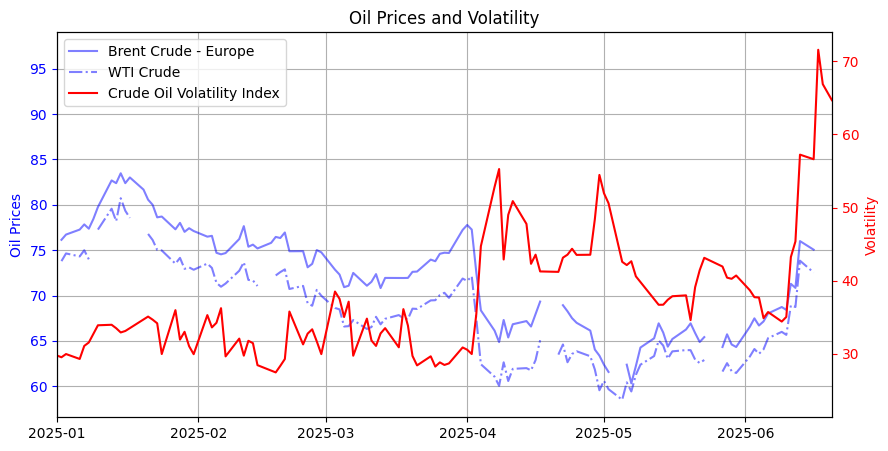

In [9]:
fig_h, ax_h = plt.subplots(figsize=(10,5))

ph1, = ax_h.plot(brent_crude.index,brent_crude.Close,label='Brent Crude - Europe',color='b',alpha=0.5)
ph2, = ax_h.plot(wti_crude.index,wti_crude.Close,label='WTI Crude',color='b',ls='-.',alpha=0.5)

plt.grid()

ax_h.set_ylabel('Oil Prices', color='b')
ax_h.tick_params('y', colors='b')

ax2_h = ax_h.twinx()
plot_ovx = ovx_hist.copy()
plot_ovx.index = plot_ovx.index.map(lambda x: pd.to_datetime(x).date())
plot_ovx = plot_ovx.loc[plot_ovx.index>=datetime.date(2023,1,1),:]
ph3, = ax2_h.plot(plot_ovx.index,plot_ovx.Close,color='r',ls='-',label='Crude Oil Volatility Index')
plt.xlim([datetime.date(2025,1,1),datetime.date(2025,6,20)])


ax2_h.set_ylabel('Volatility', color='r')
ax2_h.tick_params('y', colors='r')


plt.legend(handles=[ph1,ph2,ph3])
plt.title('Oil Prices and Volatility')
plt.show()



Note the price and volatiltity increase starting in mid-June 2025

Performing analysis of OVX over VIX, Ratio = OVX/VIX


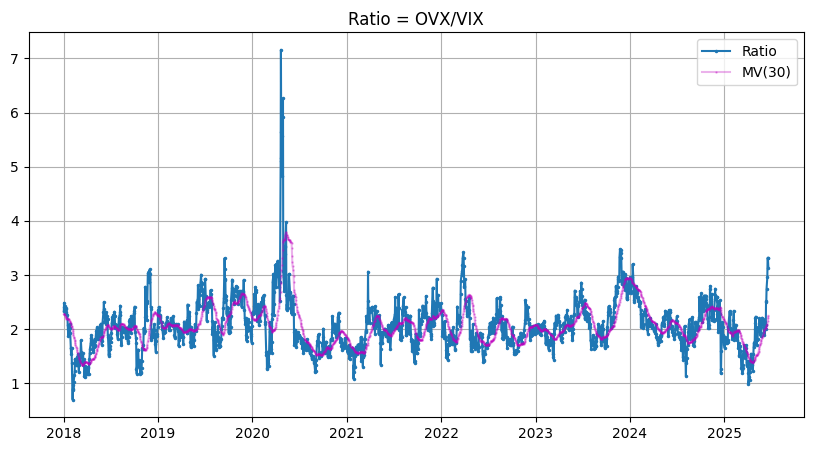

In [10]:
identified_df, ratio_df = da.main_analysis(analysis_dictionary={'OVX':ovx_hist,'VIX':vix_hist},
                                            query = None,add_histogram=False)


### Process Signal

In [11]:
ratio_df = ratio_df.rename(columns={'CloseNumerator':'OVX','CloseDenominator':'VIX'})

In [12]:
ratio_df.tail()

,OVX,VIX,Ratio,Rolling30,Diff
Date,,,,,
2025-06-13,57.230000,20.820000,2.748799,2.073145,0.675654
2025-06-16,56.599998,19.110001,2.961800,2.097519,0.864281
2025-06-17,71.559998,21.600000,3.312963,2.147911,1.165052
2025-06-18,66.860001,20.139999,3.319762,2.201839,1.117923
2025-06-20,64.669998,20.620001,3.136275,2.245999,0.890276


In [13]:
ratio_df = ratio_df.loc[ratio_df.index>=datetime.date(2018,1,1),:]

In [14]:
summary_df = pd.DataFrame()

for end_date in ratio_df.index[252:]:

    start_date = end_date - relativedelta(months=12)
    subset_df = ratio_df.loc[(ratio_df.index>=start_date)&(ratio_df.index<=end_date),:]
    period_df = pd.DataFrame(
        {'Start':subset_df.index.min(),'End':subset_df.index.max(),'Count':subset_df.shape[0],
        'Mean_Ratio':np.mean(subset_df.Ratio),'Std_Ratio':np.std(subset_df.Ratio)
        },index=[0])
    summary_df = pd.concat([summary_df,period_df],ignore_index=True)

In [15]:
summary_df.head()

,Start,End,Count,Mean_Ratio,Std_Ratio
0,2018-01-03,2019-01-03,252,1.862139,0.417119
1,2018-01-04,2019-01-04,252,1.861835,0.416691
2,2018-01-08,2019-01-07,251,1.859445,0.415819
3,2018-01-08,2019-01-08,252,1.860999,0.415723
4,2018-01-09,2019-01-09,252,1.860681,0.415417


#### Plot of the Ratio and the 1 year look back mean & standard deviation 

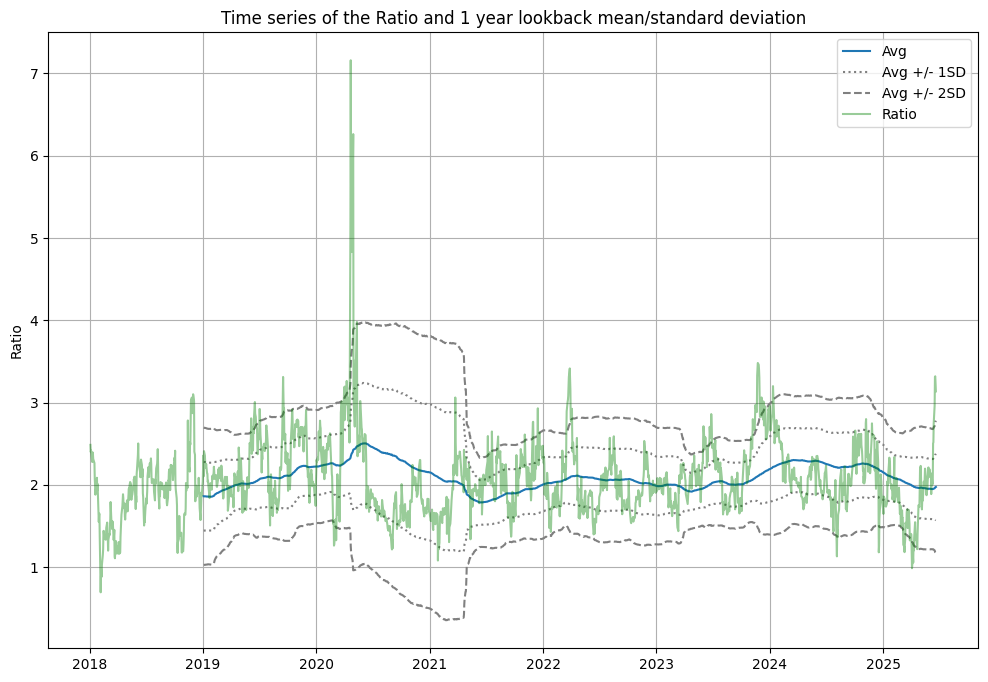

In [16]:
fig_h, ax = plt.subplots(figsize=(12,8))

p1, = plt.plot(summary_df['End'],summary_df.Mean_Ratio,label='Avg')

p2, = plt.plot(summary_df['End'],summary_df.Mean_Ratio+summary_df.Std_Ratio,label='Avg +/- 1SD',color='grey',ls=':')
p3, = plt.plot(summary_df['End'],summary_df.Mean_Ratio+2*summary_df.Std_Ratio,label='Avg +/- 2SD',color='grey',ls='--')

plt.plot(summary_df['End'],summary_df.Mean_Ratio-summary_df.Std_Ratio,label='Avg - 1SD',color='grey',ls=':')
plt.plot(summary_df['End'],summary_df.Mean_Ratio-2*summary_df.Std_Ratio,label='Avg - 2SD',color='grey',ls='--')

plot_ratio = ratio_df.loc[ratio_df.index>=summary_df['Start'].min(),:].copy()
p4, = plt.plot(plot_ratio.index,plot_ratio.Ratio,label='Ratio',color='green',alpha=0.4)

plt.legend(handles=[p1,p2,p3,p4])
plt.grid()
plt.ylabel("Ratio")

plt.title("Time series of the Ratio and 1 year lookback mean/standard deviation")
plt.show()


In [17]:
plot_ratio.loc[:,'Mean'] = np.nan
plot_ratio.loc[:,'STD'] = np.nan
for end_date in plot_ratio.index[252:]:
    start_date = end_date - relativedelta(months=12)
    subset_df = plot_ratio.loc[(plot_ratio.index>=start_date)&(plot_ratio.index<=end_date),:]
    plot_ratio.loc[subset_df.index.max(),'Mean'] = np.mean(subset_df.Ratio.to_list())
    plot_ratio.loc[subset_df.index.max(),'STD'] = np.std(subset_df.Ratio.to_list())
plot_ratio.loc[:,'Z_Score'] = ((plot_ratio.Ratio-plot_ratio.Mean)/plot_ratio.STD).to_list()
plot_ratio.loc[:,'Max_1y_Z_Score'] = plot_ratio.Z_Score.rolling(252,min_periods=100).max().to_list()

In [18]:
plot_ratio.tail()

,OVX,VIX,Ratio,Rolling30,Diff,Mean,STD,Z_Score,Max_1y_Z_Score
Date,,,,,,,,,
2025-06-13,57.230000,20.820000,2.748799,2.073145,0.675654,1.955316,0.371663,2.134951,2.134951
2025-06-16,56.599998,19.110001,2.961800,2.097519,0.864281,1.958986,0.377744,2.654744,2.654744
2025-06-17,71.559998,21.600000,3.312963,2.147911,1.165052,1.964381,0.386519,3.489047,3.489047
2025-06-18,66.860001,20.139999,3.319762,2.201839,1.117923,1.970054,0.395809,3.409998,3.489047
2025-06-20,64.669998,20.620001,3.136275,2.245999,0.890276,1.974863,0.402559,2.885075,3.489047


### Z-Scored Signal


It is important to use a rolling window to calculate the mean and standard deviation as to not have forward bias. It would be improper to use a mean & standard deviation from the whole time series to compute the Z-score. That is why I've added the mean and standard deviation in the plot to demonstrate this point.


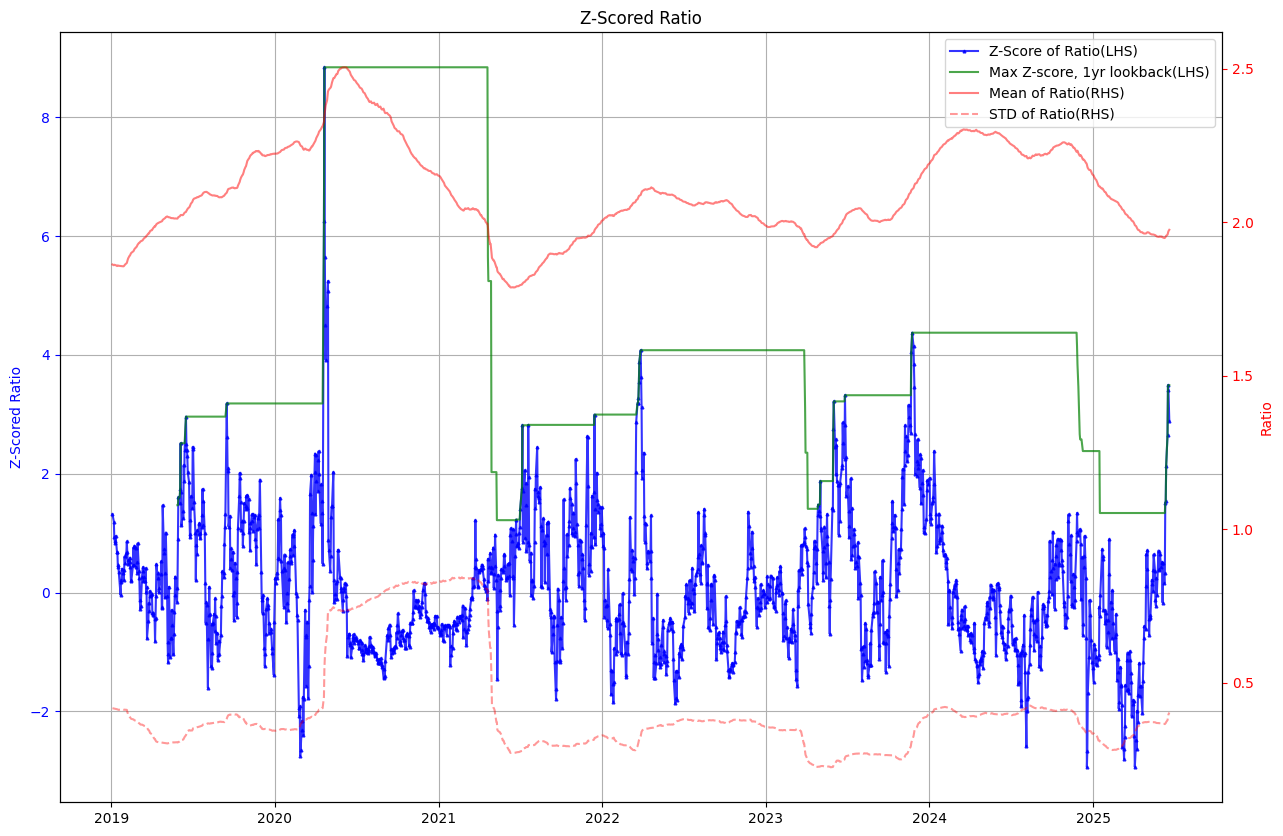

In [19]:
fig_h, ax = plt.subplots(figsize=(15,10))

p1, = ax.plot(plot_ratio.index,plot_ratio.Z_Score,color='b',marker='^',ms=2,
              alpha=0.8,label='Z-Score of Ratio(LHS)')
p4, = ax.plot(plot_ratio.index,plot_ratio.Max_1y_Z_Score,color='g',alpha=0.7,label='Max Z-score, 1yr lookback(LHS)')

ax.grid()
ax.set_ylabel('Z-Scored Ratio', color='b')
ax.tick_params('y', colors='b')


ax2 = ax.twinx()
p2, = ax2.plot(plot_ratio.index,plot_ratio.Mean,color='r',alpha=0.5,label='Mean of Ratio(RHS)')

ax2.set_ylabel('Ratio', color='r')
ax2.tick_params('y', colors='r')


p3, = ax2.plot(plot_ratio.index,plot_ratio.STD,color='r',ls='--',alpha=0.4,label='STD of Ratio(RHS)')


plt.legend(handles=[p1,p4,p2,p3])
plt.title("Z-Scored Ratio")
plt.show()

#### Simple Strategy

Lets start with a very simple strategy of entering and exiting the trade. If the z-score is above a threshold and the max Z-score value changes above a certain point I will enter a set of straddles and hold it for a set period.

Since we will be betting that the sudden increase(spike) in the ratio will come back down the 2 straddles will be the following

1. OVX: Short Options on Brent ATM Straddle
3. VIX: Long SPX ATM Straddle

Lets calculate a theoretical payoff(we will revisit the option premium once the data feed is configured) based on this strategy for one of the days where the ratio reached it's peak, whcih was on April 21st, 2020.

In [21]:
example = plot_ratio.loc[plot_ratio.index >= datetime.date(2020,4,17),:].head(13).copy()
example = example.drop(columns=['Rolling30','Diff'])
example.loc[:,'Trade_Date']=[x-2 for x in list(range(example.shape[0]))]
example

,OVX,VIX,Ratio,Mean,STD,Z_Score,Max_1y_Z_Score,Trade_Date
Date,,,,,,,,
2020-04-17,95.910004,38.150002,2.514024,2.312447,0.416616,0.483842,3.181957,-2
2020-04-20,226.130005,43.830002,5.159252,2.326138,0.453328,6.249583,6.249583,-1
2020-04-21,325.149994,45.410000,7.160317,2.345246,0.544700,8.839861,8.839861,0
2020-04-22,236.800003,41.980000,5.640781,2.358220,0.581481,5.645178,8.839861,1
2020-04-23,211.000000,41.380001,5.099082,2.370032,0.606046,4.503042,8.839861,2
2020-04-24,173.529999,35.930000,4.829669,2.380531,0.625164,3.917590,8.839861,3
2020-04-27,185.470001,33.290001,5.571343,2.396502,0.657590,4.827997,8.839861,4
2020-04-28,198.770004,33.570000,5.921061,2.410433,0.692547,5.069152,8.839861,5
2020-04-29,195.589996,31.230000,6.262888,2.425600,0.732075,5.241658,8.839861,6


In this example, the following is the process I would execute and enter the trade

- On the close of April 21st, I would see that the current ratio of 7.2 is an 8 standard deviation event. I wish to enter a trade on the next day open

- On the Open of April 22nd, I will enter the 2 ATM straddle.

  I will use the open price for this date to use as the spot. On this date, the SPX open was 2787.8 and the open for Brent was 19.55. For the sake of argument lets say the Strikes for SPX was 2800 and 20 for Brent


- Calculate the theoretical PnL , review the quantity etc (**TBD, IN PROGRESS**)

In [26]:
brent_ATM_strike = 20
spx_ATM_strike = 2800
trade_date = datetime.date(2020,4,21)


#### Spot data

In [32]:
#Brent Crude Oil Last Day Financ (BZ=F)
brent_prices = da.extract_hist_yf("BZ=F")
brent_prices.index = brent_prices.index.map(lambda x: pd.to_datetime(x).date())
brent_prices = brent_prices.loc[brent_prices.index >= datetime.date(2020,4,17),:].head(13).copy()
brent_prices = brent_prices.drop(columns=['Volume','Dividends','Stock Splits'])
brent_prices.loc[:,'Trade_Date']=example.loc[:,'Trade_Date']

Error in getting ticker information 
 'longName'
                                Open       High        Low      Close
Date                                                                 
2025-06-17 00:00:00-04:00  72.809998  77.080002  72.529999  76.449997
2025-06-18 00:00:00-04:00  77.190002  77.430000  74.440002  76.699997
2025-06-20 00:00:00-04:00  76.120003  79.019997  75.529999  77.269997


Time Series data from 2007-07-30 to 2025-06-20. Total of 4450 observation


In [23]:
spx_index = da.extract_hist_yf("^SPX")
spx_index.index = spx_index.index.map(lambda x: pd.to_datetime(x).date())
spx_index = spx_index.loc[spx_index.index >= datetime.date(2020,4,17),:].head(13).copy()
spx_index = spx_index.drop(columns=['Volume','Dividends','Stock Splits'])
spx_index.loc[:,'Trade_Date']=example.loc[:,'Trade_Date']


Long_Name='S&P 500 INDEX'
Symbol='^SPX'
                                  Open         High          Low        Close
Date                                                                         
2025-06-17 00:00:00-04:00  6012.149902  6023.250000  5974.799805  5982.720215
2025-06-18 00:00:00-04:00  5987.930176  6018.250000  5971.890137  5980.870117
2025-06-20 00:00:00-04:00  5999.669922  6018.200195  5952.560059  5967.839844


Time Series data from 1927-12-30 to 2025-06-20. Total of 24483 observation


,Open,High,Low,Close,Trade_Date
Date,,,,,
2020-04-17,2842.429932,2879.219971,2830.879883,2874.560059,-2
2020-04-20,2845.620117,2868.979980,2820.429932,2823.159912,-1
2020-04-21,2784.810059,2785.540039,2727.100098,2736.560059,0
2020-04-22,2787.889893,2815.100098,2775.949951,2799.310059,1
2020-04-23,2810.419922,2844.899902,2794.260010,2797.800049,2
2020-04-24,2812.639893,2842.709961,2791.760010,2836.739990,3
2020-04-27,2854.649902,2887.719971,2852.889893,2878.479980,4
2020-04-28,2909.959961,2921.149902,2860.709961,2863.389893,5
2020-04-29,2918.459961,2954.860107,2912.159912,2939.510010,6


In [34]:

brent_prices.loc[:,'Straddle'] = np.nan
brent_prices.loc[brent_prices.index>trade_date,'Straddle'] = abs(brent_prices.loc[brent_prices.index>trade_date,'Close']-brent_ATM_strike)

brent_prices

,Open,High,Low,Close,Trade_Date,Straddle
Date,,,,,,
2020-04-17,28.469999,29.000000,27.600000,28.080000,-2,NaN
2020-04-20,28.049999,28.240000,25.379999,25.570000,-1,NaN
2020-04-21,25.959999,27.230000,17.520000,19.330000,0,NaN
2020-04-22,19.559999,22.459999,16.000000,20.370001,1,0.370001
2020-04-23,21.299999,23.180000,20.059999,21.330000,2,1.330000
2020-04-24,21.790001,22.670000,20.510000,21.440001,3,1.440001
2020-04-27,21.299999,21.910000,19.110001,19.990000,4,0.010000
2020-04-28,20.170000,21.270000,18.730000,20.459999,5,0.459999
2020-04-29,20.750000,23.830000,20.350000,22.540001,6,2.540001


In [35]:
spx_index.loc[:,'Straddle'] = np.nan
spx_index.loc[spx_index.index>trade_date,'Straddle'] = abs(spx_index.loc[spx_index.index>trade_date,'Close']-spx_ATM_strike)
spx_index

,Open,High,Low,Close,Trade_Date,Straddle
Date,,,,,,
2020-04-17,2842.429932,2879.219971,2830.879883,2874.560059,-2,NaN
2020-04-20,2845.620117,2868.979980,2820.429932,2823.159912,-1,NaN
2020-04-21,2784.810059,2785.540039,2727.100098,2736.560059,0,NaN
2020-04-22,2787.889893,2815.100098,2775.949951,2799.310059,1,0.689941
2020-04-23,2810.419922,2844.899902,2794.260010,2797.800049,2,2.199951
2020-04-24,2812.639893,2842.709961,2791.760010,2836.739990,3,36.739990
2020-04-27,2854.649902,2887.719971,2852.889893,2878.479980,4,78.479980
2020-04-28,2909.959961,2921.149902,2860.709961,2863.389893,5,63.389893
2020-04-29,2918.459961,2954.860107,2912.159912,2939.510010,6,139.510010


In [37]:
example.loc[:,'Brent_Straddle'] = brent_prices['Straddle']
example.loc[:,'SPX_Straddle'] = spx_index['Straddle']
example

,OVX,VIX,Ratio,Mean,STD,Z_Score,Max_1y_Z_Score,Trade_Date,Brent_Straddle,SPX_Straddle
Date,,,,,,,,,,
2020-04-17,95.910004,38.150002,2.514024,2.312447,0.416616,0.483842,3.181957,-2,NaN,NaN
2020-04-20,226.130005,43.830002,5.159252,2.326138,0.453328,6.249583,6.249583,-1,NaN,NaN
2020-04-21,325.149994,45.410000,7.160317,2.345246,0.544700,8.839861,8.839861,0,NaN,NaN
2020-04-22,236.800003,41.980000,5.640781,2.358220,0.581481,5.645178,8.839861,1,0.370001,0.689941
2020-04-23,211.000000,41.380001,5.099082,2.370032,0.606046,4.503042,8.839861,2,1.330000,2.199951
2020-04-24,173.529999,35.930000,4.829669,2.380531,0.625164,3.917590,8.839861,3,1.440001,36.739990
2020-04-27,185.470001,33.290001,5.571343,2.396502,0.657590,4.827997,8.839861,4,0.010000,78.479980
2020-04-28,198.770004,33.570000,5.921061,2.410433,0.692547,5.069152,8.839861,5,0.459999,63.389893
2020-04-29,195.589996,31.230000,6.262888,2.425600,0.732075,5.241658,8.839861,6,2.540001,139.510010
